<a href="https://colab.research.google.com/github/sumi1git/myproject/blob/main/cnn_based_attention_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
                                                                                                                                                                                        # This Python 3 environment comes with many helpful analytics libraries installed
#several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


****

****DATA CLeaning****

In [ ]:
#load and read csv
#df=pd.read_csv('/gdrive/MyDrive/sumana_nuig/mvsa_multiple/mvsa_multiple_attr_scene_clean.csv')
#df=pd.read_csv('/gdrive/MyDrive/sumana_nuig/mvsa/mvsa_attr_info1_scene clean.csv')
df1=pd.read_csv('/gdrive/MyDrive/sumana_nuig/simpson/simpson_scene_clean.csv')
df2=pd.read_csv('/gdrive/MyDrive/sumana_nuig/simpson/simpson_attr_info.csv')
df=pd.merge(df1,df2,on='img_path',how='inner')
#df=df.dropna()
df.rename(columns = {'visual_label':'image_label'}, inplace = True)
#df=df.dropna()
df[:2]

,img_path,Visual_Sentiment,Textual_Sentiment,Overall_Sentiment,Unnamed: 4,sentiment,image_label,text_label,joint_label,scene_res50,scene_vgg16,scene_vgg19,text,object_names,object_score,att_name,att_score,joint_sentiment,class_att,bbox
0,img00021.jpg,0,1,0,NaN,negative,negative,neutral,negative,"['""military uniform"",', '""bulletproof vest"",',...","['""baseball player"",', '""bulletproof vest"",', ...","['""bulletproof vest"",', '""horizontal bar"",', '...",white power movement new book connect movement...,"['eye', 'man', 'man', 'man', 'sign', 'sign', '...","[0.5621907711029053, 0.5024511814117432, 0.489...","['black', 'sitting', 'sitting', 'sitting', 'wh...","[0.4743715524673462, 0.18493443727493286, 0.15...",negative,"['eye black', 'man sitting', 'man sitting', 'm...","[[525.07763671875, 236.52786254882812, 609.050..."
1,img00024.jpg,1,0,0,NaN,negative,neutral,negative,negative,"['""menu"",', '""brass"",', '""crossword"",', '""scor...","['""scoreboard"",', '""traffic sign"",', '""menu"",'...","['""dust jacket"",', '""brass"",', '""menu"",', '""sc...",lhate lama youral hat usiw anyth work jour tor...,"['floor', 'writing', 'writing', 'writing', 'wr...","[0.5603692531585693, 0.4662087559700012, 0.462...","['wooden', 'white', 'white', 'white', 'white',...","[0.304502934217453, 0.5460624694824219, 0.6122...",negative,"['floor wooden', 'writing white', 'writing whi...","[[0.0, 721.5868530273438, 416.1690368652344, 9..."


In [ ]:
#get batch of 64 we need 2844 sample
#df=df.iloc[:4288:,]

In [ ]:
df.joint_sentiment.value_counts()

positive    11313
neutral      4402
negative     1298
Name: joint_sentiment, dtype: int64

**Balancing data in the dataframe**

In [ ]:

#Blance data for MVSA-Multiple
# Downsample the data by randomly selecting 10% of the rows
#downsampled_data = data.sample(frac=0.1)

# Upsample the data by duplicating each row two times
neg=df1[df1['joint_sentiment']=='negative']
upsampled_neg = neg.reindex(neg.index.repeat(4))
print(upsampled_neg.shape)
nut=df1[df1['joint_sentiment']=='neutral']
upsampled_nut = nut.reindex(nut.index.repeat(2))
print(upsampled_nut.shape)
#downsampled_nut = nut.sample(frac=0.2)
#downsampled_nut=pd.concat([downsampled_nut,nut])
#print(upsampled_nut.shape)
pos=df1[df1['joint_sentiment']=='positive']
#downsampled_pos = pos.sample(frac=0.5)
#print(downsampled_pos.shape)
#concat three sampling
#df=pd.concat([downsampled_nut.iloc[:5000,:],upsampled_neg.iloc[:5000,:],downsampled_pos.iloc[:5000,:]])
#df=pd.concat([downsampled_pos,upsampled_nut,upsampled_neg])
df=pd.concat([pos,upsampled_nut,upsampled_neg])
print(df.shape)
df.joint_sentiment.value_counts()


(5192, 15)
(8804, 15)
(25309, 15)


positive    11313
neutral      8804
negative     5192
Name: joint_sentiment, dtype: int64

In [ ]:
"""
#Blance data for MVSA-Single
# Downsample the data by randomly selecting 10% of the rows
#downsampled_data = data.sample(frac=0.1)

# Upsample the data by duplicating each row two times
neg=df1[df1['joint_sentiment']=='negative']
upsampled_neg = neg.reindex(neg.index.repeat(2))
upsampled_neg=upsampled_neg.iloc[:2593,:]
#print(upsampled_neg.shape)
nut=df1[df1['joint_sentiment']=='neutral']
upsampled_nut = nut.reindex(nut.index.repeat(6))
upsampled_nut=upsampled_nut.iloc[:2593,:]
print(upsampled_nut.shape)
pos=df1[df1['joint_sentiment']=='positive']
upsampled_pos=pos.iloc[:2593,:]
#concat three sampling
df=pd.concat([upsampled_pos,upsampled_nut,upsampled_neg])
#df=pd.concat([pos,upsampled_nut,upsampled_neg])
df.joint_sentiment.value_counts()
print(df.shape)
"""

In [ ]:
#remove duplicate pairs of words from class_att
def drop_dupli(text):
    #seen = set()
    result = []
    seen=[]
    #c=0
    for item in text.split():
       # seen=[]
        if item not in seen:
            #seen.add(item)
            seen.append(item)
            result.append(item)
    return " ".join(result)
df['class_att1'] = df['class_att'].apply(drop_dupli)
#df['class_att1'] = df['class_att'].apply(lambda x: list(dict.fromkeys(x)))
#df.class_att1
#df['newame'] = df['Names'].apply(lambda x: list(dict.fromkeys(x)))
#print (df)

In [ ]:
df.joint_sentiment.value_counts()

In [ ]:
#For Simpson dataset
df['ctext'] = df['text'].apply(lambda x: x[:] if (len(x.split())<20) else (" ".join(x.split()[:20])))

In [ ]:
# clean data
import re
df["class_att1"] = df["class_att"].apply(lambda x: re.sub("[\[{','}\]]", ' ', str(x)).strip())
df["scene_res50"] = df["scene_res50"].apply(lambda x: re.sub("[\[{','}\]]", ' ', str(x)).strip())
df["class_att_res50"] = df["class_att"].str.cat(df["scene_res50"])
df["class_att_res50"] = df["class_att_res50"].apply(lambda x: re.sub("[\[{','}\]]", ' ', str(x)).strip())
df["cbts"] = df["ctext"].str.cat(df["class_att"])
df["cbts1"] = df["class_att_res50"].str.cat(df["ctext"])
#df["class_att1"] = df["class_att"].apply(lambda x: re.sub("[\[{','}\]]", ' ', str(x)).strip())
df[:2]

#df["class_att2"] = df["class_att1"].apply(lambda x: set(x))
#print("max len of tweets",max([len(x.split()) for x in df.class_att1]))#29
#print("max len of tweets",max([len(x.split()) for x in df.obj_name]))#29

,img_path,Visual_Sentiment,Textual_Sentiment,Overall_Sentiment,Unnamed: 4,sentiment,image_label,text_label,joint_label,scene_res50,...,att_name,att_score,joint_sentiment,class_att,bbox,ctext,class_att1,class_att_res50,cbts,cbts1
0,img00021.jpg,0,1,0,NaN,negative,negative,neutral,negative,"""military uniform"" ""bulletproof vest"" ...",...,"['black', 'sitting', 'sitting', 'sitting', 'wh...","[0.4743715524673462, 0.18493443727493286, 0.15...",negative,"['eye black', 'man sitting', 'man sitting', 'm...","[[525.07763671875, 236.52786254882812, 609.050...",white power movement new book connect movement...,eye black man sitting man sitting man...,eye black man sitting man sitting man...,white power movement new book connect movement...,eye black man sitting man sitting man...
1,img00024.jpg,1,0,0,NaN,negative,neutral,negative,negative,"""menu"" ""brass"" ""crossword"" ""scoreb...",...,"['wooden', 'white', 'white', 'white', 'white',...","[0.304502934217453, 0.5460624694824219, 0.6122...",negative,"['floor wooden', 'writing white', 'writing whi...","[[0.0, 721.5868530273438, 416.1690368652344, 9...",lhate lama youral hat usiw anyth work jour tor...,floor wooden writing white writing white...,floor wooden writing white writing white...,lhate lama youral hat usiw anyth work jour tor...,floor wooden writing white writing white...


In [ ]:
#df1["object_attr_ctext"]=df1["object_names"].str.cat(df1["att_name"])
#df["object_attr_text"]=df["class_att"].str.cat(df["text"])
df["cbt"]=df["text"].str.cat(df["class_att1"])
df[:2]

,ID,text_x,img_path,text_label,image_sentiment,joint_label,text_y,object_names,object_score,att_name,att_score,joint_sentiment,class_att,bbox,text,class_att1,cbt
0,2499,Knocked doors with the venerable #TeamTrudeau ...,2499.jpg,positive,positive,positive,Knocked doors with the venerable #TeamTrudeau ...,"['window', 'building', 'man', 'man', 'sign', '...","[0.8636385202407837, 0.8330612182617188, 0.830...","['white', 'white', 'standing', 'standing', 're...","[0.4545164406299591, 0.3220462203025818, 0.374...",positive,"['window white', 'building white', 'man standi...","[[0.0, 189.970458984375, 69.93639373779297, 37...",knock door venerable teamtrudeau lpc candidate...,window white building white man standing...,knock door venerable teamtrudeau lpc candidate...
1,2500,Canvassing for @ElectKellyYEG #yegfed #elxn42,2500.jpg,neutral,positive,positive,Canvassing for @ElectKellyYEG #yegfed #elxn42,"['door', 'door', 'door', 'boy', 'door', 'hair'...","[0.8792338371276855, 0.8491924405097961, 0.813...","['white', 'white', 'white', 'young', 'white', ...","[0.7257274985313416, 0.5963190197944641, 0.746...",positive,"['door white', 'door white', 'door white', 'bo...","[[2.5472946166992188, 0.0, 227.929931640625, 4...",canvassing electkellyyeg yegfed elxn42,door white door white door white boy ...,canvassing electkellyyeg yegfed elxn42door whi...


In [ ]:
#split train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.20)
#train_df, test_df = train_test_split(df, test_size=0.10,random_state=42)
#train_df, val_df = train_test_split(train_dff, test_size=0.1)
print(train_df.shape,test_df.shape)

(2264, 25) (566, 25)


In [ ]:
#train_df[:2]

In [ ]:
#y_train=pd.get_dummies(train_df.joint_sentiment)
#y_test=pd.get_dummies(test_df.joint_sentiment)
y_train=pd.get_dummies(train_df.image_label)
y_test=pd.get_dummies(test_df.image_label)
#y_val=pd.get_dummies(val_df.joint_sentiment)


In [ ]:
def get_label_code(text):
    if text=='positive':
        return 2
    elif text=='neutral':
        return 1
    else :
        return 0
#test_df['jlabel']=test_df['joint_label'].apply(get_label_code)
#test_df['jlabel']=test_df['joint_sentiment'].apply(get_label_code)
#test_df['jlabel']=test_df['afc'].apply(get_label_code)
test_df['ilabel']=test_df['image_label'].apply(get_label_code)
#test_df['tlabel']=test_df['tsentiment'].apply(get_label_code)
#test_df[:2]

### Filtering all the warnings sign

In [ ]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

In [ ]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


In [ ]:
#import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras_preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling2D,Bidirectional, LSTM, Dense, Input, Flatten,Dropout,GlobalMaxPool1D,MaxPooling1D,Concatenate
from tensorflow.keras.layers import SpatialDropout1D

In [ ]:

print("max len of tweets",max([len(x.split()) for x in train_df.cbt]))
print("max len of tweets",max([len(x.split()) for x in train_df.class_att1]))

max len of tweets 65
max len of tweets 54


In [ ]:
#import Glove
GLOVE_EMB = '/gdrive/MyDrive/sumana_nuig/glove.6B.300d.txt'
EMBEDDING_DIM = 300

**Sentiment of Combined text: which is concatenation of image description and Caption Text with that image **

In [ ]:
#Training and Test
def load_tarin_test_dataset(train,test,col,str_len):
    column=col
    max_len=str_len
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts( train[column])
    #tokenizer.fit_on_texts(train_df.object_attr1_text)
    #tokenizer.fit_on_texts(train_df.text)
    #tokenizer1.fit_on_texts(test_data)

    word_index = tokenizer.word_index
    vocab_size = len(tokenizer.word_index) + 1
    #print("Vocabulary Size :", vocab_size)

    #jx_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen = max_len)
    x_train = pad_sequences(tokenizer.texts_to_sequences( train[column]), maxlen = max_len)
    #x_val = pad_sequences(tokenizer.texts_to_sequences(val_df.class_att), maxlen = 32)
    #jx_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen =max_len )
    x_test = pad_sequences(tokenizer.texts_to_sequences( test[column]), maxlen =max_len )
    #y_train, y_test = train_test_split(y, test_size=1-TRAIN_SIZE,random_state=7) # Splits Dataset into Training and Testing set
    #y_train, y_test = train_test_split(df['POSITIVE'], test_size=1-TRAIN_SIZE,random_state=7)
    embeddings_index = {}

    f = open(GLOVE_EMB, encoding="utf8")
    for line in f :
        values = line.split()
        word = value = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' %len(embeddings_index))
    embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    print(embedding_matrix.shape)
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=max_len,#MAX_SEQUENCE_LENGTH,
                                          trainable=False)
    return x_train,x_test,vocab_size,embedding_layer



**Design CNN MOdel**

In [ ]:
"""
#call train test dataset
max_len=max([len(x.split()) for x in train_df.cbt])

x_train,x_test,vocab_size,embedding_layer=load_tarin_test_dataset(train_df,test_df,'cbt',max_len)
print("Vocabulary Size :", vocab_size)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)


kernel_sizes = [5,4,3]
num_filters = 100
#jsequence_input = Input(shape=(maxlen,), dtype='int32')
jsequence_input = Input(shape=(max_len,), dtype='int32')
jembedding_sequences = embedding_layer(jsequence_input)
x = SpatialDropout1D(0.2)(jembedding_sequences)
conv_layers = []
for kernel_size in kernel_sizes:
    conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(x)#(jembedding_sequences)
    pool_layer = MaxPooling1D(pool_size=max_len - kernel_size + 1)(conv_layer)
    #pool_layer = MaxPooling1D()(conv_layer)
    #pool_layer = tf.keras.layers.Reshape((1, -1))(pool_layer)
    conv_layers.append(pool_layer)

#Concatenate all convolutional layers
concatenate_layer = tf.keras.layers.Concatenate()(conv_layers)
flatten_layer = Flatten()(concatenate_layer)
x = Dropout(0.5)(flatten_layer)#(x)
#x = Conv1D(100, 4, padding='same',activation='relu')(x)
#x = Conv1D(100, 3,activation='relu')(x)
#x=Conv1D(64, 5,padding='same', kernel_initializer='he_uniform',activation='relu')(x)#(jembedding_sequences)#
#x = Dense(100, activation='relu')(x)
#x= GlobalMaxPool1D()(x)
#x = Dropout(0.5)(x)

#x=Flatten()(x)
x = Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(3, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(x)
#outputs = Dense(3,activation='softmax')(x)
modelse= tf.keras.Model(jsequence_input, outputs)
#Model Compile
from tensorflow.keras.callbacks import ReduceLROnPlateau

modelse.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',
               metrics=['categorical_accuracy'])
#modelse.compile(optimizer=optimizer, loss='categorical_crossentropy',
             # metrics=metric)#['categorical_accuracy'])

historyse = modelse.fit(x_train, y_train, epochs=10,batch_size=128, validation_split=0.1,validation_data=(x_test, y_test))

s, (at, al) = plt.subplots(2,1)
at.plot(historyse.history['categorical_accuracy'], c= 'b')
at.plot(historyse.history['val_categorical_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['CNN_train', 'CNN_val'], loc='upper left')

al.plot(historyse.history['loss'], c='m')
al.plot(historyse.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
#<matplotlib.legend.Legend at 0x7f3739c12490>
#ypred=modelse.predict(x_test)
#ypred=np.around(ypred)
predicted = modelse.predict(x_test)
bscore=modelse.evaluate(x_test,y_test)
print('Test Loss:', bscore[0])
print('Test accuracy:', bscore[1])
ypredicted = np.argmax(predicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.jlabel,ypredicted))
#from sklearn.metrics import accuracy_score,jaccard_score,pr
"""


In [ ]:

"""
def cnn_model(str_length,embeding_layer):
    max_len=str_length
    embeding_layer=embeding_layer
    #CNN for caption text
    sequence_input = Input(shape=(max_len,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    txt = SpatialDropout1D(0.1)(embedding_sequences)
    txt=Conv1D(100, 4,activation='relu')(txt)#(tembedding_sequences)#(x)
    #txt = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2))(txt)#(tembedding_sequences)
    #ttxtb = Dense(256, activation='tanh')(txtb)
    txt= GlobalMaxPool1D()(txt)
    txt=Flatten()(txt)
    txt = Dense(256, activation='tanh')(txt)
    return sequence_input,txt
"""

In [ ]:
def cnn_model(num_filters,kernel_size,string_length,embeding_layer):
    num_filters=num_filters
    kernel_size=kernel_size
    #jsequence_input = Input(shape=(maxlen,), dtype='int32')
    sequence_input = Input(shape=(max_len,), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    conv_layers = []
    for num_filters,kernel_size in zip(num_filters,kernel_size):
        conv_layer = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(x)#(jembedding_sequences)
        pool_layer = MaxPooling1D(pool_size=max_len - kernel_size + 1)(conv_layer)
        #pool_layer = MaxPooling1D()(conv_layer)
        #pool_layer = tf.keras.layers.Reshape((1, -1))(pool_layer)
        conv_layers.append(pool_layer)

    #Concatenate all convolutional layers
    concatenate_layer = tf.keras.layers.Concatenate()(conv_layers)
    flatten_layer = Flatten()(concatenate_layer)
    x = Dropout(0.5)(flatten_layer)#(x)
    txt = Dense(256, activation='tanh')(x)

    #x = Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation='relu')(x)
    #x = Dropout(0.5)(x)
    #outputs = Dense(3, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(x)
    #outputs = Dense(3,activation='softmax')(x)
    #model= tf.keras.Model(jsequence_input, outputs)
    #return model
    return sequence_input,txt
#modelse=cnn_model(num_filters,kernel_sizes,max_len,embedding_layer)

**Extract Caption text features**

In [ ]:
#For Caprion text


max_len=max([len(x.split()) for x in train_df.text])
#tx_train,tx_test,vocab_size,embedding_layer=load_tarin_test_dataset(train_df,test_df,'text',max([len(x.split()) for x in train_df.text]))
tx_train,tx_test,vocab_size,embedding_layer=load_tarin_test_dataset(train_df,test_df,'text',max_len)
print("Vocabulary Size :", vocab_size)
print("Training X Shape:",tx_train.shape)
print("Testing X Shape:",tx_test.shape)
#call train text dataset
kernel_sizes = [4,3,2]
num_filters = [200,150,100]
text_input,ttxt=cnn_model(num_filters,kernel_sizes,max_len,embedding_layer)

Found 400000 word vectors.
(29947, 300)
Vocabulary Size : 29947
Training X Shape: (15311, 19)
Testing X Shape: (1702, 19)


**Extract Class-attributes features **

In [ ]:
#For class-attributes pairs

#call train test dataset
max_len=max([len(x.split()) for x in train_df.class_att1])
#tx_train,tx_test,vocab_size,embedding_layer=load_tarin_test_dataset(train_df,test_df,'text',max([len(x.split()) for x in train_df.text]))
ax_train,ax_test,vocab_size,embedding_layer=load_tarin_test_dataset(train_df,test_df,'class_att1',max_len)
print("Vocabulary Size :", vocab_size)
print("Training X Shape:",ax_train.shape)
print("Testing X Shape:",ax_test.shape)
#call CNN model
kernel_sizes = [4,3,2]
num_filters = [32,16,8]
atclass_input,tcl=cnn_model(num_filters,kernel_sizes,max_len,embedding_layer)


Found 400000 word vectors.
(595, 300)
Vocabulary Size : 595
Training X Shape: (2264, 42)
Testing X Shape: (566, 42)


In [ ]:

#call train test dataset
max_len=max([len(x.split()) for x in train_df.scene_res50])
#tx_train,tx_test,vocab_size,embedding_layer=load_tarin_test_dataset(train_df,test_df,'text',max([len(x.split()) for x in train_df.text]))
sx_train,sx_test,vocab_size,embedding_layer=load_tarin_test_dataset(train_df,test_df,'scene_res50',max_len)
print("Vocabulary Size :", vocab_size)
print("Training X Shape:",sx_train.shape)
print("Testing X Shape:",sx_test.shape)
#call CNN model
kernel_sizes = [4,3,2]
num_filters = [32,16,8]
scene_input,scene=cnn_model(num_filters,kernel_sizes,max_len,embedding_layer)

Found 400000 word vectors.
(1017, 300)
Vocabulary Size : 1017
Training X Shape: (2264, 22)
Testing X Shape: (566, 22)


In [ ]:

#call train test dataset
max_len=max([len(x.split()) for x in train_df.class_att_res50])
#tx_train,tx_test,vocab_size,embedding_layer=load_tarin_test_dataset(train_df,test_df,'text',max([len(x.split()) for x in train_df.text]))
jx_train,jx_test,vocab_size,embedding_layer=load_tarin_test_dataset(train_df,test_df,'class_att_res50',max_len)
print("Vocabulary Size :", vocab_size)
print("Training X Shape:",jx_train.shape)
print("Testing X Shape:",jx_test.shape)
#call CNN model
kernel_sizes = [5,4,3]
num_filters = [64,32,16]
ca_scene_input,ca_scene=cnn_model(num_filters,kernel_sizes,max_len,embedding_layer)

Found 400000 word vectors.
(1417, 300)
Vocabulary Size : 1417
Training X Shape: (2264, 62)
Testing X Shape: (566, 62)


In [ ]:
rcl = tf.keras.layers.Reshape((1, -1))(tcl)
rttxt = tf.keras.layers.Reshape((1, -1))(ca_scene)
# Combine class-att and caption text pathways using attention mechanism
attention1 = tf.keras.layers.AdditiveAttention()([rcl, rttxt])
#attention1 = tf.keras.layers.GlobalMaxPool1D()(attention1)
#frcl=Flatten()(rcl)
frttxt=Flatten()(rttxt)
fattention1=Flatten()(attention1)
at1 =  tf.keras.layers.Concatenate()([frttxt, fattention1])
at1 = Dense(256, activation='relu')(at1)

Epoch 1/30
64/64 [==============================] - 10s 24ms/step - loss: 0.5482 - accuracy: 0.8606 - val_loss: 2.1654 - val_accuracy: 0.6123
Epoch 2/30
64/64 [==============================] - 1s 15ms/step - loss: 0.2719 - accuracy: 0.8974 - val_loss: 1.8070 - val_accuracy: 0.6123
Epoch 3/30
64/64 [==============================] - 1s 12ms/step - loss: 0.2417 - accuracy: 0.9224 - val_loss: 1.6700 - val_accuracy: 0.6167
Epoch 4/30
64/64 [==============================] - 1s 10ms/step - loss: 0.2294 - accuracy: 0.9185 - val_loss: 1.8462 - val_accuracy: 0.5991
Epoch 5/30
64/64 [==============================] - 1s 11ms/step - loss: 0.2077 - accuracy: 0.9303 - val_loss: 2.6752 - val_accuracy: 0.6256
Epoch 6/30
64/64 [==============================] - 1s 12ms/step - loss: 0.2626 - accuracy: 0.9062 - val_loss: 2.2514 - val_accuracy: 0.5991
Epoch 7/30
64/64 [==============================] - 1s 12ms/step - loss: 0.2678 - accuracy: 0.9175 - val_loss: 2.4554 - val_accuracy: 0.6300
Epoch 8/30
6

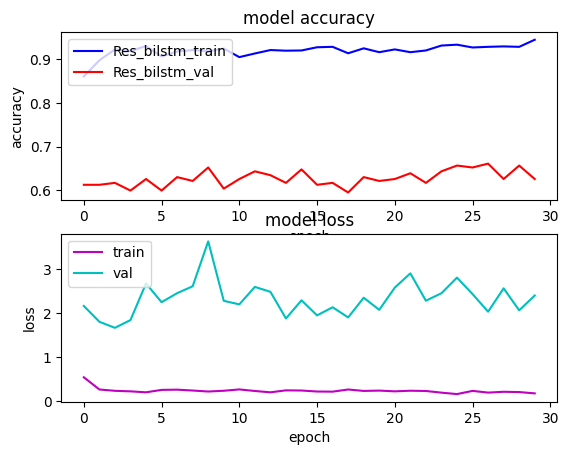

In [ ]:
fat1=Flatten()(at1)
#fca_scene=Flatten()(ca_scene)
fusion2 = tf.keras.layers.Concatenate()([fat1,tcl,scene,ca_scene])
#fusion2 = tf.keras.layers.Concatenate()([tcl,scene,ca_scene])
fusion2 = Dense(256,activation='relu')(fusion2)#(att_input_layer)
fusion2 = Dropout(0.5)(fusion2)
fusion2_out = Dense(3,activation='softmax')(fusion2)
# Defining model input and output
f2model = tf.keras.Model(inputs = [atclass_input,scene_input,ca_scene_input], outputs=fusion2_out)
# Compile the model
f2model.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.005),# optimizer,#image_input
    loss = 'categorical_crossentropy',#loss
    metrics =['accuracy'])
# metric)#Max length 55 with ctext with class name with joint label
f2history = f2model.fit(
    x =[ax_train,sx_train,jx_train],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
   # ),
 validation_split = 0.1,
  epochs=30,
    batch_size=32
)

#text classification without english stop word and max word length 80
f2predicted = f2model.predict([ax_test,sx_test,jx_test])
#com_score=f2model.evaluate([ax_test,sx_test,jx_test],y_test)
#print('Test Loss:', com_score[0])
#print('Test accuracy:', com_score[1])
#f2ypredicted = np.argmax(f2predicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
#from sklearn.metrics import classification_report
#print(classification_report(test_df.ilabel,f2ypredicted))

#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(f2history.history['accuracy'], c= 'b')
at.plot(f2history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Res_bilstm_train', 'Res_bilstm_val'], loc='upper left')

al.plot(f2history.history['loss'], c='m')
al.plot(f2history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
from sklearn.metrics import classification_report
ypredicted = np.argmax(f2predicted,axis=1)
print(classification_report(test_df.ilabel,ypredicted,digits=4))
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
acc=accuracy_score(test_df.ilabel,ypredicted)
bal_acc=balanced_accuracy_score(test_df.ilabel,ypredicted)
recall=recall_score(test_df.ilabel,ypredicted,average='weighted')
precision=precision_score(test_df.ilabel,ypredicted,average='weighted')
f1=f1_score(test_df.ilabel,ypredicted,average='weighted')
print(acc,bal_acc,recall,precision,f1)

In [ ]:
"""
#CNN for caption text
tsequence_input = Input(shape=(max_len,), dtype='int32')
tembedding_sequences = tembedding_layer(tsequence_input)
txt = SpatialDropout1D(0.1)(tembedding_sequences)
#txt=Conv1D(100, 4,padding='same',activation='relu')(txt)#(tembedding_sequences)#(x)
txt = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2))(txt)#(tembedding_sequences)
#ttxtb = Dense(256, activation='tanh')(txtb)
ttxt = Dense(128, activation='tanh')(txt)
#gtxt= GlobalMaxPool1D()(txt)
dtxt = Dense(128, activation='relu')(txt)
#cl = Conv1D(256, 5, activation='relu')(cl)
outputs = Dense(3, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(dtxt)
#outputs = Dense(3,activation='softmax')(x)
tmodel= tf.keras.Model(tsequence_input, outputs)
#Model Compile
from tensorflow.keras.callbacks import ReduceLROnPlateau

tmodel.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
"""

**Attention of class-attributes and caption text**

In [ ]:
rcl = tf.keras.layers.Reshape((1, -1))(tcl)
rttxt = tf.keras.layers.Reshape((1, -1))(ttxt)
# Combine class-att and caption text pathways using attention mechanism
attention1 = tf.keras.layers.AdditiveAttention()([rcl, rttxt])
#attention1 = tf.keras.layers.GlobalMaxPool1D()(attention1)
#frcl=Flatten()(rcl)
frttxt=Flatten()(rttxt)
fattention1=Flatten()(attention1)
at1 =  tf.keras.layers.Concatenate()([frttxt, fattention1])
at1 = Dense(256, activation='relu')(at1)
#at1 = Dropout(0.5)(at1)
#output = layers.Dense(num_classes, activation='softmax')(x)
#at1_out = Dense(3,activation='softmax')(at1)#(con_out)
#out = Dense(3,activation='softmax')(con_layer)

# Defining model input and output
#at1_model = tf.keras.Model(inputs = [jsequence_input,tsequence_input], outputs=at1_out)

In [ ]:
#at1_model.summary()

**Combined Text Features Extraction**

**Visual Features Extraction**

In [ ]:
import cv2

#collect all images from original file of Simpson
impath_list=train_df['img_path'].tolist()
#sentiment=imdf['visual_label'].tolist()
#path='../input/simpson-original-data/Dataset/Dataset/'
path='/gdrive/MyDrive/sumana_nuig/mvsa_multiple/data/'
#path='/gdrive/MyDrive/sumana_nuig/mvsa/data/'

train_img_file=[]
#sent=[]
img_size=(224,224)
#for file,s in zip(impath_list,sentiment):
for file in impath_list:
    #nfile=str(file)
    #img=cv2.imread(path+nfile+'.jpg')
    img=cv2.imread(path+file)
    img=cv2.resize(img,img_size)
    train_img_file.append(img)
    #sent.append(s)
#convert images into array
#imgarx_train=np.array(train_img_file)
vx_train=np.array(train_img_file)
print(vx_train.shape)
#dummies for labels
#print(len(sent))
#dff=pd.DataFrame()
#dff['sentiment']=pd.DataFrame(sent)


(15311, 224, 224, 3)


In [ ]:
#import cv2
#collect all images from original file of Simpson
impath_list=test_df['img_path'].tolist()
#sentiment=imdf['visual_label'].tolist()
#path='../input/simpson-original-data/Dataset/Dataset/'
path='/gdrive/MyDrive/sumana_nuig/mvsa_multiple/data/'
#path='/gdrive/MyDrive/sumana_nuig/mvsa/data/'

test_img_file=[]
#sent=[]
img_size=(224,224)
#for file,s in zip(impath_list,sentiment):
for file in impath_list:
    #nfile=str(file)
    #img=cv2.imread(path+nfile+'.jpg')
    img=cv2.imread(path+file)
    img=cv2.resize(img,img_size)
    test_img_file.append(img)
    #sent.append(s)
#convert images into array
vx_test=np.array(test_img_file)
print(vx_test.shape)

In [ ]:
data = np.load('/gdrive/MyDrive/sumana_nuig/mvsa/mvsa_multiple_vx_train_test.npz')


# Access the variables inside the npz file

vx_train = data['a']
vx_test = data['b']
print(vx_train.shape,vx_test.shape)

(15311, 224, 224, 3) (1702, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import VGG16,VGG19,ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense, Dropout, Flatten,BatchNormalization,concatenate,Bidirectional,LSTM
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt

In [ ]:

# Instantiate convolutional base mode for whole image
image_input = Input(shape=(224, 224, 3), name='image')
resnet = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))#(image_input)
for layer in resnet.layers:
    layer.trainable=False
#res_layer = Dense(256, activation='tanh')(resnet)
res_layer=Flatten()(resnet.output)
res_layer = Dense(256, activation='tanh')(res_layer)
res_layer1 = Dense(256, activation='relu')(res_layer)
#res_layer = Dense(256, activation='relu')(resnet.output)
#res_layer = Flatten()(resnet.output) #(vgg16)#
#res_layer_32=Dense(32, activation='relu')(res_layer)
img_model=Dropout(0.5)(res_layer1)
vprediction = Dense(3, activation='softmax')(img_model)
rmodel = tf.keras.Model(inputs=resnet.input, outputs=vprediction)
#rmodel.summary()
#img_model.summary()
#rmodel.compile(loss='categorical_crossentropy',
#                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
 #                  metrics=metric)#['accuracy'])


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
"""
# Define image pathway

image_input = Input(shape=(224, 224, 3), name='image')
x_image = Conv2D(32, (3, 3), activation='relu')(image_input)
x_image = MaxPooling2D(pool_size=(2, 2))(x_image)
x_image = Conv2D(64, (3, 3), activation='relu')(x_image)
x_image = MaxPooling2D(pool_size=(2, 2))(x_image)
x_image = Flatten()(x_image)
res_layer = Dense(128, activation='relu')(x_image)
"""

**Attention layer of  image and Class-att text**

In [ ]:

#new
#when image and text data for cross attention
#example
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Dot, Softmax, Multiply, Concatenate, Conv2D, MaxPooling2D, Flatten

def cross_attention(query, key, value):
    # compute the attention scores between query and key
    scores = Dot(axes=-1)([query, key])
    scores = Softmax(axis=-1)(scores)

    # apply the attention scores to the value sequence
    context = Dot(axes=1)([scores, value])
    context = tf.keras.layers.Reshape((1, -1))(context )
    #context=Flatten()(context)
    # concatenate the query and context vectors
    output = Concatenate()([query, context])
    return output




In [ ]:
tcl = tf.keras.layers.Reshape((1, -1))(tcl)
res_layer = tf.keras.layers.Reshape((1, -1))( res_layer)

at2_context = cross_attention(tcl, res_layer, res_layer)
at2_context=Flatten()(at2_context)
at2 = Dense(256, activation='relu')(at2_context)

In [ ]:
rat1 = tf.keras.layers.Reshape((1, -1))(at1)
rat2 = tf.keras.layers.Reshape((1, -1))( at2)
# apply cross-attention to the text input and the image features
#context = cross_attention(text_input, flatten, flatten)
context = cross_attention(rat1, rat2, rat2)
context=Flatten()(context)
at3 = Dense(256, activation='relu')(context)
#at3 = Dropout(0.5)(context)
#at3_out = Dense(3, activation='softmax')(at3)

# create the model
#at3_model = tf.keras.Model(inputs = [jsequence_input,tsequence_input,image_input], outputs=at3_out)
#model = keras.models.Model(inputs=[image_input, text_input], outputs=output)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
"""
# Ensure that the dimensions of the image and text outputs are compatible
tcl = tf.keras.layers.Reshape((1, -1))(tcl)
res_layer = tf.keras.layers.Reshape((1, -1))( res_layer)
# Attention layer of  image and Class-att text

attention2 = tf.keras.layers.AdditiveAttention()([tcl, res_layer])

#gres_layer1 = tf.keras.layers.GlobalMaxPool2D()(res_layer1)
#attention2 = tf.keras.layers.GlobalMaxPool2D()(attention2)
# Concatenate image and attention pathway
#x = layers.Concatenate(axis=-1)([x_image, attention])

fres_layer=Flatten()(res_layer)
fattention2=Flatten()(attention2)
at2 =  tf.keras.layers.Concatenate()([fres_layer, fattention2])
at2 = Dense(256, activation='relu')(at2)
#output = layers.Dense(num_classes, activation='softmax')(x)
at2_out = Dense(3,activation='softmax')(at2)#(con_out)
#out = Dense(3,activation='softmax')(con_layer)

# Defining model input and output
#at2_model = tf.keras.Model(inputs = [jsequence_input,rmodel.input], outputs=at2_out)
"""

In [ ]:
#at2_model.summary()

In [ ]:
"""
# metric)#Max length 55 with ctext with class name with joint label
at2_model.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),# optimizer,#image_input
    loss = 'categorical_crossentropy',#loss
    metrics =['accuracy'])
com_history = at2_model.fit(
    x =[jx_train,vx_train],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
   # ),
 validation_split = 0.1,
  epochs=20,
    batch_size=64
)

#text classification without english stop word and max word length 80
cpredicted = at2_model.predict([jx_test,vx_test])
com_score=at2_model.evaluate([jx_test,vx_test],y_test)
print('Test Loss:', com_score[0])
print('Test accuracy:', com_score[1])
cypredicted = np.argmax(cpredicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.jlabel,cypredicted))
#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(com_history.history['accuracy'], c= 'b')
at.plot(com_history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Res_bilstm_train', 'Res_bilstm_val'], loc='upper left')

al.plot(com_history.history['loss'], c='m')
al.plot(com_history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
"""

**Cross modal attention**

**Attention based image+text model**

In [ ]:
#at3_model.summary()

Epoch 1/10
108/108 [==============================] - 50s 400ms/step - loss: 1.2522 - accuracy: 0.5625 - val_loss: 0.8144 - val_accuracy: 0.5940
Epoch 2/10
108/108 [==============================] - 43s 398ms/step - loss: 0.8492 - accuracy: 0.5839 - val_loss: 0.8114 - val_accuracy: 0.6181
Epoch 3/10
108/108 [==============================] - 44s 404ms/step - loss: 0.8439 - accuracy: 0.5902 - val_loss: 0.8082 - val_accuracy: 0.5973
Epoch 4/10
108/108 [==============================] - 44s 407ms/step - loss: 0.8429 - accuracy: 0.5903 - val_loss: 0.8059 - val_accuracy: 0.6077
Epoch 5/10
108/108 [==============================] - 45s 416ms/step - loss: 0.8385 - accuracy: 0.5771 - val_loss: 0.8157 - val_accuracy: 0.5881
Epoch 6/10
108/108 [==============================] - 45s 417ms/step - loss: 0.8435 - accuracy: 0.5747 - val_loss: 0.8117 - val_accuracy: 0.5933
Epoch 7/10
108/108 [==============================] - 45s 420ms/step - loss: 0.8424 - accuracy: 0.5799 - val_loss: 0.8102 - val_ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


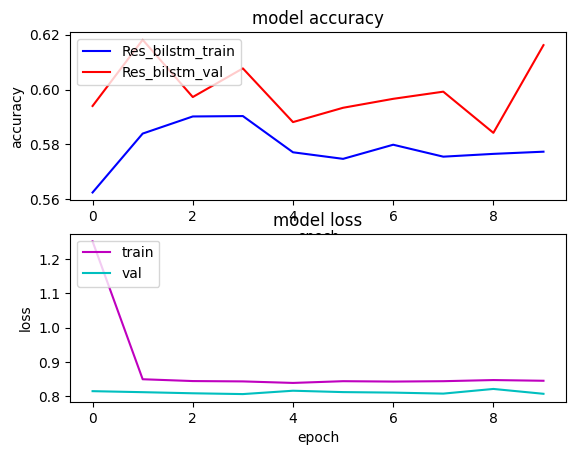

In [ ]:
at2 = Dense(256, activation='relu')(at2_context)
fat2=Flatten()(at2)
fres_layer=Flatten()(res_layer)
fusion2 = tf.keras.layers.Concatenate()([fat2,fres_layer])
fusion2 = Dense(256,activation='relu')(fusion2)#(att_input_layer)
fusion2 = Dropout(0.5)(fusion2)
fusion2_out = Dense(3,activation='softmax')(fusion2)
# Defining model input and output
f2model = tf.keras.Model(inputs = [atclass_input,resnet.input], outputs=fusion2_out)
# Compile the model
f2model.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.01),# optimizer,#image_input
    loss = 'categorical_crossentropy',#loss
    metrics =['accuracy'])
# metric)#Max length 55 with ctext with class name with joint label
f2history = f2model.fit(
    x =[jx_train,vx_train],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
   # ),
 validation_split = 0.1,
  epochs=10,
    batch_size=128
)

#text classification without english stop word and max word length 80
f2predicted = f2model.predict([jx_test,vx_test])
com_score=f2model.evaluate([jx_test,vx_test],y_test)
print('Test Loss:', com_score[0])
print('Test accuracy:', com_score[1])
f2ypredicted = np.argmax(f2predicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.ilabel,f2ypredicted))

#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(f2history.history['accuracy'], c= 'b')
at.plot(f2history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Res_bilstm_train', 'Res_bilstm_val'], loc='upper left')

al.plot(f2history.history['loss'], c='m')
al.plot(f2history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')



In [ ]:
#Fusion model with caption text
#fat3=Flatten()(at3)
fat2=Flatten()(at2)
#fusion1 = Dense(256,activation='relu')(fat3)
fres_layer=Flatten()(res_layer)
ftxt=Flatten()(ttxt)
#concatination fusion -1 with caption text,cross attention and image  global features
fusion1 = tf.keras.layers.Concatenate()([ftxt,fat2,fres_layer])
fusion1 = Dense(256,activation='relu')(fusion1)#(att_input_layer)
fusion1 = Dropout(0.5)(fusion1)
fusion1_out = Dense(3,activation='softmax')(fusion1)

f1_model = tf.keras.Model(inputs = [atclass_input,text_input,resnet.input], outputs=fusion1_out)
#com_atmodel = tf.keras.Model(inputs = [jsequence_input,tsequence_input,sequence_input,rmodel.input], outputs=conout)
#com_model.summary()
# Using Stochastic gradient descent with optimizer
# Compile the model


In [ ]:
#f1_model.summary()

In [ ]:

f1_model.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.001),# optimizer,#image_input
    loss = 'categorical_crossentropy',#loss
    metrics =['accuracy'])
with tf.device('/device:GPU:0'): #when GPU is used
    com_history = f1_model.fit(
        x =[jx_train,tx_train,vx_train],
        y = y_train,#to_categorical(train_df.tlabel),
        #validation_data = ([vx_test,
        #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
      # ),
    validation_split = 0.1,
      epochs=10,
        batch_size=128
    )

    #text classification without english stop word and max word length 80
    f1predicted = f1_model.predict([jx_test,tx_test,vx_test])
    com_score=f1_model.evaluate([jx_test,tx_test,vx_test],y_test)
    print('Test Loss:', com_score[0])
    print('Test accuracy:', com_score[1])
    f1ypredicted = np.argmax(f1predicted,axis=1)
    #y_predicted = np.where(predicted>0.5,1,0)
    from sklearn.metrics import classification_report
    print(classification_report(test_df.jlabel,f1ypredicted))
    #accuracy vs loss function
    s, (at, al) = plt.subplots(2,1)
    at.plot(com_history.history['accuracy'], c= 'b')
    at.plot(com_history.history['val_accuracy'], c='r')
    at.set_title('model accuracy')
    at.set_ylabel('accuracy')
    at.set_xlabel('epoch')
    at.legend(['Res_cnn_train', 'Res_cnn_val'], loc='upper left')

    al.plot(com_history.history['loss'], c='m')
    al.plot(com_history.history['val_loss'], c='c')
    al.set_title('model loss')
    al.set_ylabel('loss')
    al.set_xlabel('epoch')
    al.legend(['train', 'val'], loc = 'upper left')



Epoch 1/10
  6/108 [>.............................] - ETA: 58:10 - loss: 1.6186 - accuracy: 0.5234  

In [ ]:
kernel_sizes = [4,3,2]
num_filters = [200,150,100]
max_len=max([len(x.split()) for x in train_df.cbt])
x_train,x_test,vocab_size,embedding_layer=load_tarin_test_dataset(train_df,test_df,'cbt',max_len)
print("Vocabulary Size :", vocab_size)
print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)
cbt_input,tcbt=cnn_model(num_filters,kernel_sizes,max_len,embedding_layer)
#cbt_input,tcbt=cnn_model(num_filters,kernel_sizes,max_len,embedding_layer)
fcbt=Flatten()(tcbt)
#Fusion-2 with combine -text
#fusion2 = tf.keras.layers.Concatenate()([fcbt,fat3])
fusion2 = tf.keras.layers.Concatenate()([fcbt,fat3,fres_layer])
fusion2 = Dense(256,activation='relu')(fusion2)#(att_input_layer)
fusion2 = Dropout(0.5)(fusion2)
fusion2_out = Dense(3,activation='softmax')(fusion2)
# Defining model input and output
f2model = tf.keras.Model(inputs = [atclass_input,text_input,cbt_input,resnet.input], outputs=fusion2_out)
# Compile the model
f2model.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.01),# optimizer,#image_input
    loss = 'categorical_crossentropy',#loss
    metrics =['accuracy'])
# metric)#Max length 55 with ctext with class name with joint label
f2history = f2model.fit(
    x =[jx_train,tx_train,x_train,vx_train],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
   # ),
 validation_split = 0.1,
  epochs=10,
    batch_size=128
)

#text classification without english stop word and max word length 80
f2predicted = f2model.predict([jx_test,tx_test,x_test,vx_test])
com_score=f2model.evaluate([jx_test,tx_test,x_test,vx_test],y_test)
print('Test Loss:', com_score[0])
print('Test accuracy:', com_score[1])
f2ypredicted = np.argmax(f2predicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.jlabel,f2ypredicted))
#print(classification_report(test_df.jlabel,f2ypredicted,zero_division=1))
#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(f2history.history['accuracy'], c= 'b')
at.plot(f2history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Res_bilstm_train', 'Res_bilstm_val'], loc='upper left')

al.plot(f2history.history['loss'], c='m')
al.plot(f2history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')


In [ ]:
#svm model for final setiment analysis
from sklearn import svm
#from sklearn.model_selection import train_test_split

# assuming X is the concatenated feature vector and y is the label for each data point
X_train, X_test, y_train, y_test = train_test_split(train_combined_global_local_text_features, train_df.joint_sentiment, test_size=0.1, random_state=42)

# create SVM classifier
clf = svm.SVC(kernel='linear', C=1, probability=True)

# train the classifier on the training data
clf.fit(X_train, y_train)

# evaluate the classifier on the test data
print(accuracy)
# evaluate the classifier on the test data
accuracy = clf.score(X_test, y_test)
predicted = clf.predict(X_test)

#ypredicted = np.argmax(predicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(y_test,predicted))


In [ ]:
"""
#Fusion model with combined text fetures
#fat3=Flatten()(at3)
#fres_layer=Flatten()(res_layer1)

fcbt=Flatten()(dcbt)
fusion2 = tf.keras.layers.Concatenate()([fcbt,fat3,fres_layer])
fusion2 = Dense(128,activation='relu')(fusion2)#(att_input_layer)
fusion2 = Dropout(0.5)(fusion2)
fusion2_out = Dense(3,activation='softmax',name='f2')(fusion2)
#out = Dense(3,activation='softmax')(con_layer)

# Defining model input and output
f2model = tf.keras.Model(inputs = [jsequence_input,tsequence_input,sequence_input,image_input], outputs=fusion2_out)
#com_atmodel = tf.keras.Model(inputs = [jsequence_input,tsequence_input,sequence_input,rmodel.input], outputs=conout)
#com_model.summary()
# Using Stochastic gradient descent with optimizer
# Compile the model
f2model.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),# optimizer,#image_input
    loss = 'categorical_crossentropy',#loss
    metrics =['accuracy'])
# metric)#Max length 55 with ctext with class name with joint label
f2history = f2model.fit(
    x =[jx_train,tx_train,x_train,vx_train],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
   # ),
 validation_split = 0.1,
  epochs=5,
    batch_size=64
)

#text classification without english stop word and max word length 80
f2predicted = f2model.predict([jx_test,tx_test,x_test,vx_test])
com_score=f2model.evaluate([jx_test,tx_test,x_test,vx_test],y_test)
print('Test Loss:', com_score[0])
print('Test accuracy:', com_score[1])
f2ypredicted = np.argmax(f2predicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.jlabel,f2ypredicted,zero_division=1))
#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(f2history.history['accuracy'], c= 'b')
at.plot(f2history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Res_bilstm_train', 'Res_bilstm_val'], loc='upper left')

al.plot(f2history.history['loss'], c='m')
al.plot(f2history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
"""



In [ ]:
#MLP(V+C)
#MLP(S+C)
#F = λF1 + (1 − λ)F2
#F=(1-0.2)*t_cl+(0.2*im_cl)
#F=(1-0.2)*bert_cl+(0.2*img_cl)
#con_layer=Flatten()(F)

In [ ]:
"""
#rat3 = tf.keras.layers.Reshape((1, -1))(at3)
#fat3=Flatten()(rat3)
#ff2 = tf.keras.layers.Reshape((1, -1))(ff2)
#rcbt=tf.keras.layers.Reshape((1, -1))(dcbt)
#fcbt=Flatten()(rcbt)
f1=tf.keras.layers.Concatenate()([fres_layer,fat3])
f1 = Dense(256,activation='relu')(f1)
ff1=Flatten()(f1)
fat1=Flatten()(at1)
f2=tf.keras.layers.Concatenate()([ftxt,fat1])
#f2=tf.keras.layers.Concatenate()([fcbt,fat2])
f2 = Dense(256,activation='relu')(f2)
# Ensure that the dimensions of the image and text outputs are compatible
ff2=Flatten()(f2)
#ff1 = tf.keras.layers.Reshape((1, -1))(ff1)
#ff2 = tf.keras.layers.Reshape((1, -1))(ff2)
#ff1=Flatten()(at3)
#ff2=Flatten()(dcbt)
mf1=(0.1*ff1)
mf2=(0.2*ff2)
fusion3 = tf.keras.layers.Concatenate()([mf1,mf2])
conout = Dense(256,activation='relu')(fusion3)#(att_input_layer)
conout = Dropout(0.5)(conout)
conout = Dense(3,activation='softmax')(conout)
#out = Dense(3,activation='softmax')(con_layer)

# Defining model input and output
com_atmodel = tf.keras.Model(inputs = [atclass_input,text_input,resnet.input], outputs=conout)
#com_atmodel = tf.keras.Model(inputs = [jsequence_input,tsequence_input,sequence_input,rmodel.input], outputs=conout)
#com_model.summary()
# Using Stochastic gradient descent with optimizer
# Compile the model
com_atmodel.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.001),# optimizer,#image_input
    loss = 'categorical_crossentropy',#loss
    metrics =['accuracy'])
com_history = com_atmodel.fit(
    x =[jx_train,tx_train,vx_train],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
   # ),
 validation_split = 0.1,
  epochs=10,
    batch_size=128
)

#text classification without english stop word and max word length 80
cpredicted = com_atmodel.predict([jx_test,tx_test,vx_test])
com_score=com_atmodel.evaluate([jx_test,tx_test,vx_test],y_test)
print('Test Loss:', com_score[0])
print('Test accuracy:', com_score[1])
cypredicted = np.argmax(cpredicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.jlabel,cypredicted,zero_division=1))
#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(com_history.history['accuracy'], c= 'b')
at.plot(com_history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Res_cnn_train', 'Res_cnn_val'], loc='upper left')

al.plot(com_history.history['loss'], c='m')
al.plot(com_history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
"""

**Image and caption text fusion model**

**Mean of four multimodal data**

In [ ]:
"""
ff1=Flatten()(f1)
ffusion1=Flatten()(fusion1)
ffusion2=Flatten()(fusion2)
mean=(ff1+ffusion1+ffusion2+ffusion3)/4
conout = Dense(256,activation='relu')(mean)#(att_input_layer)
conout = Dropout(0.5)(conout)
conout = Dense(3,activation='softmax')(conout)
#out = Dense(3,activation='softmax')(con_layer)

# Defining model input and output
com_atmodel = tf.keras.Model(inputs = [jsequence_input,tsequence_input,sequence_input,image_input], outputs=conout)
#com_atmodel = tf.keras.Model(inputs = [jsequence_input,tsequence_input,sequence_input,rmodel.input], outputs=conout)
#com_model.summary()
# Using Stochastic gradient descent with optimizer
# Compile the model
com_atmodel.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),# optimizer,#image_input
    loss = 'categorical_crossentropy',#loss
    metrics =['accuracy'])
com_history = com_atmodel.fit(
    x =[jx_train,tx_train,x_train,vx_train],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
   # ),
 validation_split = 0.1,
  epochs=10,
    batch_size=64
)

#text classification without english stop word and max word length 80
cpredicted = com_atmodel.predict([jx_test,tx_test,x_test,vx_test])
com_score=com_atmodel.evaluate([jx_test,tx_test,x_test,vx_test],y_test)
print('Test Loss:', com_score[0])
print('Test accuracy:', com_score[1])
cypredicted = np.argmax(cpredicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.jlabel,cypredicted,zero_division=1))
#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(com_history.history['accuracy'], c= 'b')
at.plot(com_history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Res_bilstm_train', 'Res_bilstm_val'], loc='upper left')

al.plot(com_history.history['loss'], c='m')
al.plot(com_history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
"""

****ENDDD*******************************************************

In [ ]:
#!pip install transformers

#### Loading Pretrained BERT Model

In [ ]:
#from transformers import AutoTokenizer,TFBertModel
#btokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
#bert = TFBertModel.from_pretrained('bert-large-uncased')

In [ ]:
#tokenizer('this is me abhishek and i am a very bad boy &*&*&&')

#### Convert Our text data into BERT input format

In [ ]:
#print("max len of tweets",max([len(x.split()) for x in train_df.text_x]))
#print("max len of tweets",max([len(x.split()) for x in train_df.object_attr1_text]))
#max_length = 40

**Data processing for object class name**

In [ ]:
'''
tx_train = btokenizer(
    text=train_df.text_cl_at1.tolist(),
    #text=train_df.object_attr1_text.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


tx_test = btokenizer(
    text=test_df.text_cl_at1.tolist(),
    #text=test_df.object_attr1_text.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
print(tx_train['input_ids'].shape,tx_train['attention_mask'].shape,tx_test['input_ids'].shape)
#print(tx_val['input_ids'].shape,tx_val['attention_mask'].shape)
#jy_train=pd.get_dummies(train_df.joint_label)
#jy_test=pd.get_dummies(test_df.joint_label)
#print(jy_train.shape,jy_test.shape)
'''

**Train and test Data process for clean text**

In [ ]:
#### Building the model architecture

In [ ]:
"""
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten,BatchNormalization,concatenate,Multiply
from tensorflow.python.keras import regularizers
"""


In [ ]:
"""
max_len = 70
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids,attention_mask = input_mask)[0]


embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)
# out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
#out = Dropout(0.1)(embeddings)
tbert_text = Dense(128,activation = 'tanh')(embeddings)#(out)
dbert_text = Dense(128,activation = 'relu')(embeddings)#(out)
out = Dense(32, activation='relu')(dbert_text)#(out)
#bout=Flatten()(embeddings)
#out = Dense(128, activation='relu')(out)
#out = Dropout(0.1)(out)
#out = Dense(32, activation='relu')(out)
out = Dropout(0.1)(out)
#y = Dense(1,activation = 'sigmoid')(out)
y = Dense(3,activation = 'softmax')(out)

bmodel = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
bmodel.layers[2].trainable = True#False#
# for training bert our lr must be so small'''
"""


In [ ]:
"""
optimizer = Adam(
    learning_rate=3e-06,#6e-06 # this learning rate is for bert model , taken from huggingface website
    epsilon=1e-08,#1e-08
    decay=1e-5,#,#1e-5
    clipnorm=1.0)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
#metric = CategoricalAccuracy('balanced_accuracy'),

metric = [
       tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
       tf.keras.metrics.Precision(name='precision'),
       tf.keras.metrics.Recall(name='recall')
]
# Compile the model
bmodel.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric)
"""

In [ ]:
"""
rat3 = tf.keras.layers.Reshape((1, -1))(at3)
fat3=Flatten()(rat3)
#ff2 = tf.keras.layers.Reshape((1, -1))(ff2)
rcbt=tf.keras.layers.Reshape((1, -1))(dbert_text)
fcbt=Flatten()(rcbt)
f1=tf.keras.layers.Concatenate()([fres_layer,fat3])
f1 = Dense(256,activation='relu')(f1)
ff1=Flatten()(f1)
f2=tf.keras.layers.Concatenate()([fcbt,fat3])
ff = Dense(256,activation='relu')(f2)
# Ensure that the dimensions of the image and text outputs are compatible
ff2=Flatten()(f2)
#ff1 = tf.keras.layers.Reshape((1, -1))(ff1)
#ff2 = tf.keras.layers.Reshape((1, -1))(ff2)
mf1=(0.2*ff1)
mf2=(0.8)*ff2
fusion = tf.keras.layers.Concatenate()([mf1,mf2])
# = tf.keras.layers.Concatenate()([mf1,mf2])
conout = Dense(256,activation='relu')(fusion)#(att_input_layer)
#conout = Dropout(0.5)(conout)
conout = Dense(3,activation='softmax')(conout)
#out = Dense(3,activation='softmax')(con_layer)

# Defining model input and output
com_atmodel = tf.keras.Model(inputs = [jsequence_input,tsequence_input,image_input,bmodel.input], outputs=conout)
#com_atmodel = tf.keras.Model(inputs = [jsequence_input,tsequence_input,sequence_input,rmodel.input], outputs=conout)
#com_model.summary()
# Using Stochastic gradient descent with optimizer
# Compile the model
com_atmodel.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),# optimizer,#image_input
    loss = 'categorical_crossentropy',#loss
    metrics =['accuracy'])
com_history = com_atmodel.fit(
    x =[jx_train,tx_train,vx_train,{'input_ids':tx_train['input_ids'],'attention_mask':tx_train['attention_mask']}],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
   # ),
 validation_split = 0.1,
  epochs=10,
    batch_size=64
)

#text classification without english stop word and max word length 80
cpredicted = com_atmodel.predict([jx_test,tx_test,vx_test,{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}])
com_score=com_atmodel.evaluate([jx_test,tx_test,vx_test,{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test)
print('Test Loss:', com_score[0])
print('Test accuracy:', com_score[1])
cypredicted = np.argmax(cpredicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.jlabel,cypredicted,zero_division=1))
#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(com_history.history['accuracy'], c= 'b')
at.plot(com_history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Res_bilstm_train', 'Res_bilstm_val'], loc='upper left')

al.plot(com_history.history['loss'], c='m')
al.plot(com_history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
"""

In [ ]:
#plot_model(bmodel, show_shapes = True)

In [ ]:
"""
# Instantiate convolutional base mode for whole image

image_input = Input(shape=(224, 224, 3), name='image16')
vgg16 = VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))#(image_input)
for layer in vgg16.layers:
    layer.trainable=False

#v16_layer = Flatten()(vgg16.output) #(vgg16)#
v16_layer = Dense(256,activation = 'relu')(vgg16.output)#(out)
#img_layer=Dense(4024, activation='relu')(vgg16.output)
img_model=Dropout(0.5)(v16_layer)
vprediction = Dense(3, activation='softmax')(img_model)
wmodel = tf.keras.Model(inputs=vgg16.input, outputs=vprediction)
#wmodel.summary()
#img_model.summary()
wmodel.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics=['accuracy'])#metric)#
"""


In [ ]:
"""
# Concatenating the last layer of two model global+bert
v16_layer=Flatten()(v16_layer)
bert_text=Flatten()(bert_text)
con_layer = concatenate([v16_layer,bert_text])
con_layer=Flatten()(con_layer)
#con_layer=LSTM(128, return_sequences=True)(con_layer)
#x = LSTM(512, return_sequences=False)(x)
#con_out = Dense(2048,activation='relu')(con_layer)
#con_out = Dropout(0.5)(con_out)
#con_out = Dense(1024,activation='sigmoid')(con_out)
con_out = Dropout(0.2)(con_layer)
con_out = Dense(3,activation='softmax')(con_out)
#out = Dense(3,activation='softmax')(con_layer)

# Defining model input and output
com_model = tf.keras.Model(inputs = [wmodel.input,model.input], outputs=con_out)
#com_model.summary()
# Using Stochastic gradient descent with optimizer
# Compile the model
com_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),#optimizer,#
    loss = 'categorical_crossentropy',#loss
    metrics = metric)#Max length 55 with ctext with class name with joint label
com_history = com_model.fit(
    x =[vx_train,{'input_ids':tx_train['input_ids'],'attention_mask':tx_train['attention_mask']}],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],jy_test #to_categorical(test_df.tlabel)
    #),
  validation_split = 0.1,
  epochs=10,
    batch_size=32
)

#text classification without english stop word and max word length 80
cpredicted = com_model.predict([vx_test,{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}])
com_score=com_model.evaluate([vx_test,{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test)
print('Test Loss:', com_score[0])
print('Test accuracy:', com_score[1])
cypredicted = np.argmax(cpredicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.jlabel,cypredicted))
#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(com_history.history['accuracy'], c= 'b')
at.plot(com_history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['BERT_train', 'BERT_val'], loc='upper left')

al.plot(com_history.history['loss'], c='m')
al.plot(com_history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
"""


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [ ]:
"""
con_layer = Dense(128,activation='relu')(con_layer)
#con_layer = Dense(128,activation='relu')(F)#(con_layer)
#con_layer=LSTM(128, return_sequences=True)(F)
#x = LSTM(512, return_sequences=False)(x)
#con_out = Dense(256,activation='relu')(con_layer)
#con_out = Dropout(0.5)(con_out)
#con_out = Dense(1024,activation='sigmoid')(con_out)
con_out = Dropout(0.2)(con_layer)
con_out = Dense(3, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='softmax')(con_out)
#con_out = Dense(3, activation='softmax')(con_out)
#out = Dense(3,activation='softmax')(con_layer)

# Defining model input and output
com_model = tf.keras.Model(inputs = [jsequence_input,rmodel.input,model.input], outputs=con_out)
#com_model = tf.keras.Model(inputs = [modelse.jsequence_input,rmodel.input,model.input], outputs=con_out)
#com_model = tf.keras.Model(inputs = [iclmodel.input,tclmodel.input], outputs=con_out)
#com_model.summary()
# Using Stochastic gradient descent with optimizer
# Compile the model
com_model.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.001),# optimizer,#
    loss = 'categorical_crossentropy',#loss
    metrics = metric)#Max length 55 with ctext with class name with joint label
com_history = com_model.fit(
    x =[jx_train,vx_train,{'input_ids':tx_train['input_ids'],'attention_mask':tx_train['attention_mask']}],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
   # ),
 validation_split = 0.1,
  epochs=10,
    batch_size=32
)

#text classification without english stop word and max word length 80
cpredicted = com_model.predict([jx_test,vx_test,{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}])
com_score=com_model.evaluate([jx_test,vx_test,{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test)
print('Test Loss:', com_score[0])
print('Test accuracy:', com_score[1])
cypredicted = np.argmax(cpredicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.jlabel,cypredicted))
#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(com_history.history['accuracy'], c= 'b')
at.plot(com_history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Res_BERT_train', 'Res_BERT_val'], loc='upper left')

al.plot(com_history.history['loss'], c='m')
al.plot(com_history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
"""


In [ ]:
"""
# Concatenating the last layer of two model global+bert
res_layer=Flatten()(res_layer)
bilstm=Flatten()(bilstm)
con_layer = concatenate([res_layer,bilstm])
#con_layer=Flatten()(con_layer)
#con_layer=LSTM(128, return_sequences=True)(con_layer)
#x = LSTM(512, return_sequences=False)(x)
con_out = Dense(256,activation='relu')(con_layer)
#con_out = Dropout(0.5)(con_out)
#con_out = Dense(1024,activation='sigmoid')(con_out)
con_out = Dropout(0.2)(con_layer)
con_out = Dense(3,activation='softmax')(con_out)
#out = Dense(3,activation='softmax')(con_layer)

# Defining model input and output
com_model = tf.keras.Model(inputs = [rmodel.input,modelse.input], outputs=con_out)
#com_model.summary()
# Using Stochastic gradient descent with optimizer
# Compile the model
com_model.compile(
    optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),# optimizer,#
    loss = 'categorical_crossentropy',#loss
    metrics =['accuracy'])# metric)#Max length 55 with ctext with class name with joint label
com_history = com_model.fit(
    x =[vx_train,jx_train],
    y = y_train,#to_categorical(train_df.tlabel),
    #validation_data = ([vx_test,
    #{'input_ids':tx_test['input_ids'],'attention_mask':tx_test['attention_mask']}],y_test #to_categorical(test_df.tlabel)
   # ),
 validation_split = 0.1,
  epochs=30,
    batch_size=32
)

#text classification without english stop word and max word length 80
cpredicted = com_model.predict([vx_test,jx_test])
com_score=com_model.evaluate([vx_test,jx_test],y_test)
print('Test Loss:', com_score[0])
print('Test accuracy:', com_score[1])
cypredicted = np.argmax(cpredicted,axis=1)
#y_predicted = np.where(predicted>0.5,1,0)
from sklearn.metrics import classification_report
print(classification_report(test_df.jlabel,cypredicted))
#accuracy vs loss function
s, (at, al) = plt.subplots(2,1)
at.plot(com_history.history['accuracy'], c= 'b')
at.plot(com_history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Res_bilstm_train', 'Res_bilstm_val'], loc='upper left')

al.plot(com_history.history['loss'], c='m')
al.plot(com_history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')
"""

